BiRNN model for sentence classification using BiRNN model

In [ ]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import torch
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import random
random.seed(1)
SEED = 1337
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.decomposition import PCA
from nltk.util import ngrams
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import seaborn as sn
import copy
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from copy import deepcopy
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
#from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tqdm import tqdm
from tensorflow.keras.initializers import Zeros,glorot_uniform #RandomUniform
from tqdm import tqdm
%matplotlib inline
import csv 
from tensorflow.keras.models import model_from_json
import pickle
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
import tensorflow as tf
tf.__version__

'2.1.1'

In [ ]:
# try to read it as pandas dataframe
df = pd.read_pickle("calls_ver2.pkl", compression=None)
N = len(df)
agent_duration_secs = []
agent_largest_monologue_secs = []
agent_words_per_minute = []
customer_duration_secs = []
customer_largest_monologue_secs = []
duration_secs = []
intents = []
interrupts_by_agent = []
interrupts_by_customer = []
overall_intent = []
patience_secs = []
switches = []
actor = [] 
dialogues = [] 
 
counter = 0
for i in range(N):
    j = df[i]
#read data of each dialogue
    po = j.overall_intent
    if po == 'complaint':
        counter += 1
    else:
        overall_intent.append(po)
        agent_duration_secs.append(j.agent_duration_secs)
        agent_largest_monologue_secs.append(j.agent_largest_monologue_secs)
        agent_words_per_minute.append(j.agent_words_per_minute)
        customer_duration_secs.append(j.customer_duration_secs)
        customer_largest_monologue_secs.append(j.customer_largest_monologue_secs)
        duration_secs.append(j.duration_secs)
        interrupts_by_agent.append(j.interrupts_by_agent)
        interrupts_by_customer.append(j.interrupts_by_customer)
        patience_secs.append(j.patience_secs)
        switches.append(j.switches)
    #read the data of each segment
        seg = j.segments
        NN = len(seg)
        speaker = NN*[0]
        seg_intent = NN*[0]
        seg_sentence = [0]*NN
        for k in range(NN):
            speaker[k] = seg[k].actor
            seg_intent[k] = seg[k].intent 
            seg_sentence[k] = seg[k].sentence    
        actor.append(speaker)
        intents.append(seg_intent)
        dialogues.append(seg_sentence)

        
# add a feature "~" to any word used by customer
pro_dialogues = deepcopy(dialogues)
for i in range(len(dialogues)):
    for j in range(len(dialogues[i])):
        if actor[i][j] == 'agent':
            pass
        else:
            for k in range(len(dialogues[i][j])):
                pro_dialogues[i][j][k] = 'πελατη' + dialogues[i][j][k]


# gather info from all sentences
sent_actor = [item for sublist in actor for item in sublist]
sent_intent = [item for sublist in intents for item in sublist]
sentences = [item for sublist in dialogues for item in sublist]
pro_sentences = [item for sublist in pro_dialogues for item in sublist]
words = [item for sublist in sentences for item in sublist]
pro_words = [item for sublist in pro_sentences for item in sublist]
vocabulary = set(words)
pro_vocabulary = set(pro_words)
print(len(vocabulary))
print(len(pro_vocabulary))
vocab_size = len(vocabulary)

# make a list of stopwords
arthra = ['ο', 'του', 'τον', 'οι', 'των', 'τουσ', 'η', 'τησ' ,'την', 'τη', 'τισ', 'το', 'τα', 'στα', 'στο', 'στον', 'στουσ']
prothemata = ['να', 'απο', 'από', 'και', 'επί', 'επι']
antwnumies = ['μου', 'με', 'σου', 'σε', 'σας','σασ']
staggering = ['α', 'αα', 'ε', 'εε', 'ο', 'οο', 'ω', 'ωω', 'ι','ιι' ,'ηη']
alla = ['ειναι', 'είναι', 'θα', 'για','ναι', 'καλημέρα', 'πώς', 'τι']
my_stopwords = arthra + prothemata + antwnumies + staggering + alla
print(len(my_stopwords))

for i in range(len(my_stopwords)):
    my_stopwords.append('πελατη'+my_stopwords[i])
print(len(my_stopwords)) 



4990
6669
48
96


In [ ]:
# define functions to make the code more pretty !
def train_dev_test_splitter(X,Y,fraction=0.2,seed=1):
    x_nontest, x_test, y_nontest, y_test = train_test_split(X,Y,stratify=Y,random_state=seed, test_size=fraction)
    return x_nontest, y_nontest, x_test, y_test
    
def cosine(vec1,vec2):
    return 1 - spatial.distance.cosine(vec1,vec2)

def text_centroid(text, model):
    text_vec =[]
    counter = 0
    sent_text = nltk.sent_tokenize(text)
    for sentence in sent_text:
        sent_tokenized = nltk.word_tokenize(sentence)
        for word in sent_tokenized:
            try:
                if counter == 0:
                    text_vec = model[word.lower()]
                else:
                    text_vec = np.add(text_vec, model[word.lower()])
                counter+=1
            except:
                pass
    return np.asarray(text_vec)/counter

def centroid_data(input_text,model):
    output_centroid = []
    for i in input_text:
        output_centroid.append(text_centroid(i,model))   
    return np.stack(output_centroid, axis=0)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

def plot(history):
    # summarize history for f1
#    plt.plot(history.history['f1'])
 #   plt.plot(history.history['val_f1'])
  #  plt.title('Model f1')
   # plt.ylabel('f1-score')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'dev'], loc='upper left')
    #plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.show()
    return


. ονομάζομαι αλέπη πωσ μπορώ εξυπηρετήσω . καλησπέρα . γειά σωστά στην πειραιώσ περιστέρι πειραιώσ 50 νέο φάληρο ωραία . πιο πολύ βολεύει εκεί βάρησ κορωπίου πόσο στοιχίζει 25 . 30 ευρώ κόστοσ ελέγχου . ανεβάσατε γιατί ήταν 25 . 30 πλέον . ωραία δίνεται αυτά τρία δώρα που αναφέρεται σάιτ . παίρνετε δώρο έναν φακό . . λάμπεσ ασφάλειεσ ανταλλακτικά αν κάνετε κράτησή ιστοσελίδα μασ επιπλέον γάντια . γάντια έξτρα δώρο που γράφει αναφέρει . είσαστε στην αρχική σελίδα που λέει μπούκ ονλάιν ωραία ωραία . ζητά στοιχεία όνομα επώνυμο ιμέιλ κινητό τηλέφωνο αριθμό κυκλοφορίασ . πινακίδα . αριθμόσ κυκλοφορίασ . . βάζω εγώ προχωράω παίρνω απλά επιβεβαίωση . πάρετε επιβεβαίωση ότι ήταν επιτυχήσ κράτηση έρθει μετά μήνυμα κινητό επιβεβαίωση ραντεβού κανονικά έρχεστε ραντεβού μάλιστα . έλλησ 9 προθεσμία έχω . ωραία έχετε μέχρι πέμπτη 16 ιανουαρίου . 16 . θέλετε πείτε πινακίδα επιβεβαιώσουμε . έχει έρθει μήνυμα χι ζήτα όμικρον . . 92 . ωραία . ίδιοσ είμαι . κύριοσ βελισσάρησ εννέα πρώτου έληξε οπότε μέχ

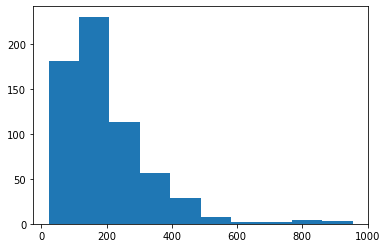

In [ ]:
# prepare the dialogue data 
x = []
po = []
fasttext_data = []
for i in range(len(dialogues)):
    j = dialogues[i]
    k = []
    previous_speaker = ' '
    for l in range(len(j)):
        current_speaker = actor[i][l]
        if current_speaker == previous_speaker:
            pass
        else:
            k.append('.')
        for m in j[l]:
            if m in my_stopwords:
                pass
            else:
                k.append(m)
        previous_speaker = current_speaker
    fasttext_data.append(k)
    
po = [[' '.join(i)] for i in fasttext_data]
for i in po:
    x.append(i[0])


y = overall_intent.copy()
x_nontest_text, y_nontest, x_test_text, y_test = train_dev_test_splitter(x, y, fraction=0.1,seed=1)
x_train_text, y_train, x_dev_text, y_dev = train_dev_test_splitter(x_nontest_text, y_nontest, fraction=0.15,seed=1)

print(x_train_text[0])
print()
print(y_train[0])
print()

# check the length of the dialogues
po = [] 
for i in dialogues:
    popo = []
    for j in i:
         popo += j
    po.append(popo)
kl = []
for i in po:
    kl.append(len(i))
    
print(np.mean(kl))
print(plt.hist(kl))
#print(sn.violinplot(kl))
mn = 0
for i in kl:
    if i > 400:
        mn +=1 
vocab = 5000 + 1
max_length = 400
print("\n\ndialogues with over " , max_length, " words :" , mn, "\n\n")

def tokenizer_converter(data, my_tokenizer, maxlength = max_length):
    sequences = my_tokenizer.texts_to_sequences(data)
    padded_seqs = pad_sequences(sequences, maxlen=maxlength,padding='post')
    return padded_seqs

tokenizer = Tokenizer(num_words=vocab,oov_token='__UNK__')
tokenizer.fit_on_texts(x_train_text)
x_train = tokenizer_converter(x_train_text, tokenizer)
x_dev = tokenizer_converter(x_dev_text, tokenizer)
x_test = tokenizer_converter(x_test_text, tokenizer)
x_nontest = tokenizer_converter(x_nontest_text, tokenizer)

def y_convert(my_y):
    return_y = []
    for i in my_y:
        if i == 'information':
            return_y.append([1,0,0])
        elif i == 'other':
            return_y.append([0,1,0])
        else:
            return_y.append([0,0,1])
    return return_y

ytrain_vector = y_convert(y_train)
ydev_vector = y_convert(y_dev)
ytest_vector = y_convert(y_test)
ynontest_vector = y_convert(y_nontest)
y_vector = y_convert(y)        
                

print(x_train[0])
print()
print(ytrain_vector[0])

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

vocab_words = list(word_index.keys())[:vocab]
embeddings_index = {}

Found 4270 unique tokens.


In [ ]:
#np.save("dialogue_embedding_matrix.npy", embedding_matrix, allow_pickle=True)
embedding_matrix = np.load("embedding_matrix.npy")

In [ ]:
embedding_dim = 300
print(embedding_matrix.shape)


(5001, 300)


In [ ]:
from numpy.random import seed
seed(1)
#import tensorflow as tf
#tf.random.set_seed(1)
import random
random.seed(1)


classes = len(set(y))
# hyperparameters
initializer = glorot_uniform(seed=1) # Zeros()
recurrent_initializer = glorot_uniform(seed=1) # Zeros()
dense_initializer = glorot_uniform(seed=1)

layers = [2]
recurrent_dropout = [0.0]# ,0.]
recurrent_neurons = [75,100]
dense_neurons = [75,150]
first_dropout = [0.]
later_dropout = [0.1,0.2]
activation = ['relu','tanh']
final_activation = 'softmax'
learning_rate = [0.0001, 0.001]
learning_rate_rate = [1]


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 300)          1500300   
_________________________________________________________________
dropout (Dropout)            (None, 400, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150)               225600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 75)                11325     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0     

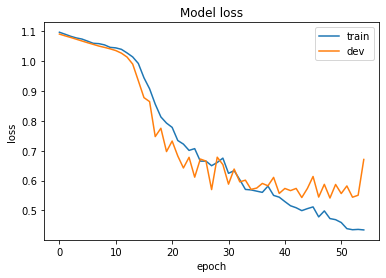

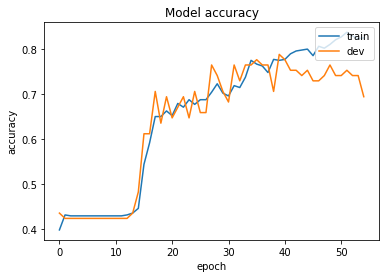

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75)                0   

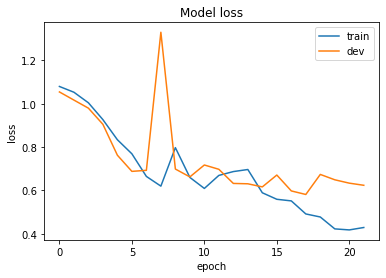

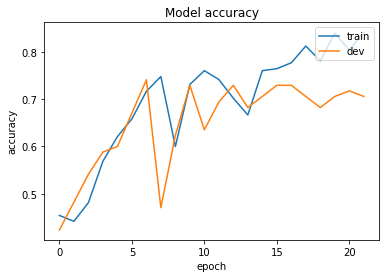

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_6 (Dropout)          (None, 400, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_8 (Dropout)          (None, 75)                0   

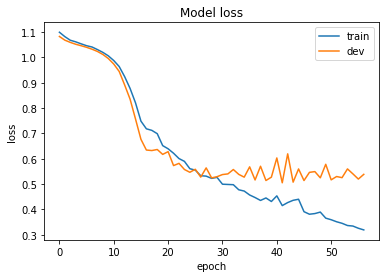

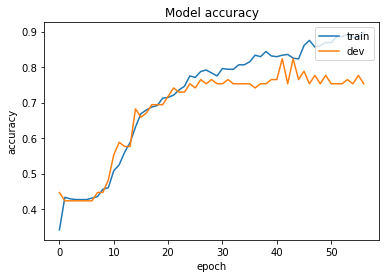

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_9 (Dropout)          (None, 400, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_11 (Dropout)         (None, 75)                0   

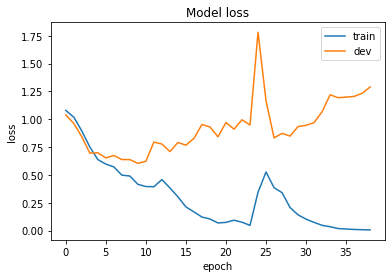

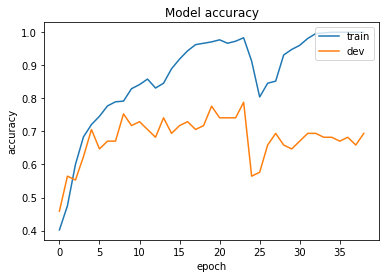

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_12 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_14 (Dropout)         (None, 75)                0   

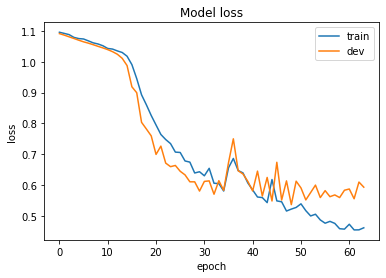

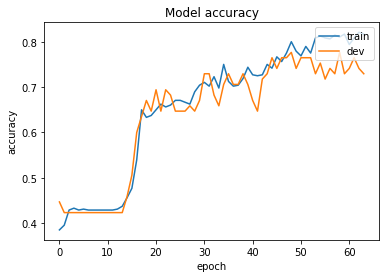

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_15 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_17 (Dropout)         (None, 75)                0   

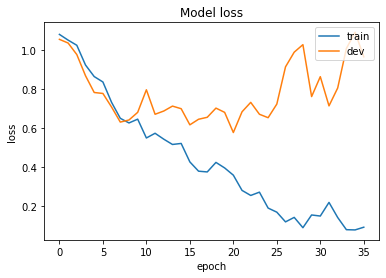

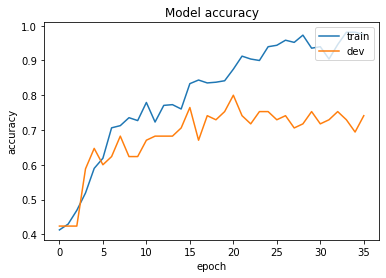

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_18 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_19 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_20 (Dropout)         (None, 75)                0   

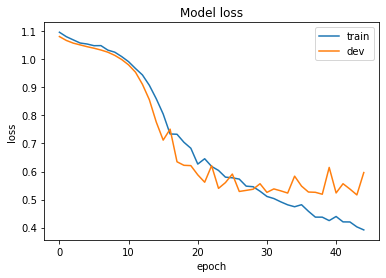

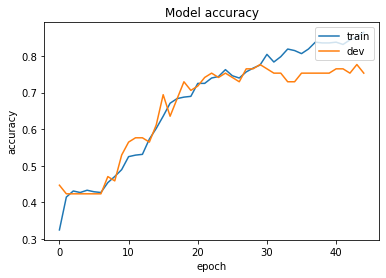

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_21 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_22 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_23 (Dropout)         (None, 75)                0   

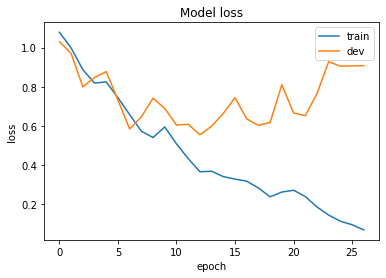

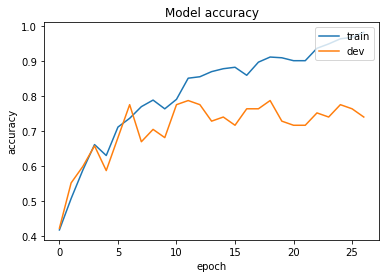

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_24 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_25 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_26 (Dropout)         (None, 150)               0   

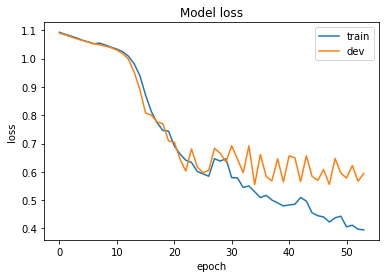

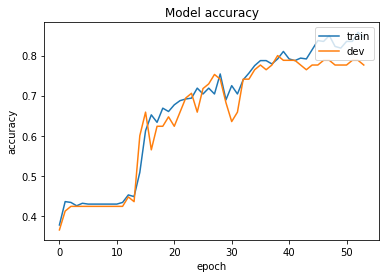

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 400, 300)          1500300   
_________________________________________________________________
dropout_27 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 150)               225600    
_________________________________________________________________
dropout_28 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_29 (Dropout)         (None, 150)               0   

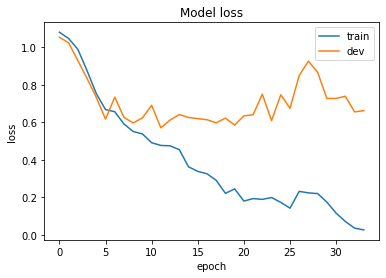

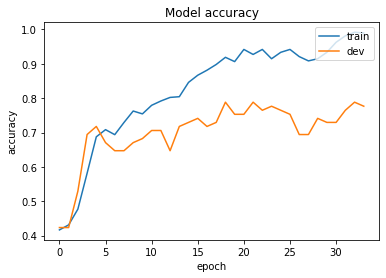

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_30 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_31 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_32 (Dropout)         (None, 150)               0  

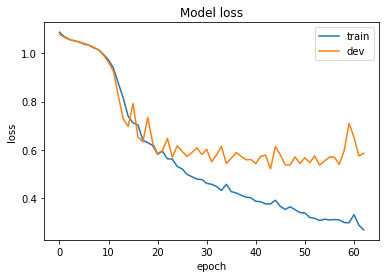

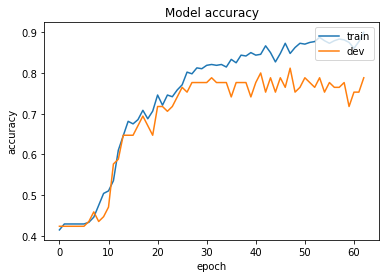

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_33 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_34 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_35 (Dropout)         (None, 150)               0  

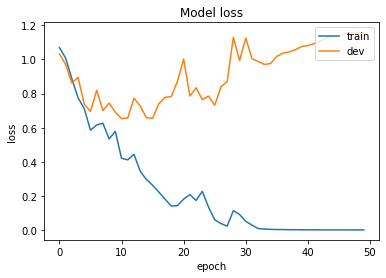

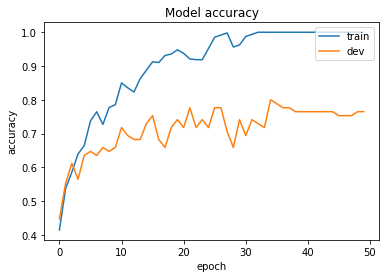

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_36 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_37 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_38 (Dropout)         (None, 150)               0  

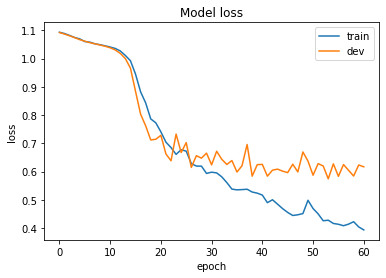

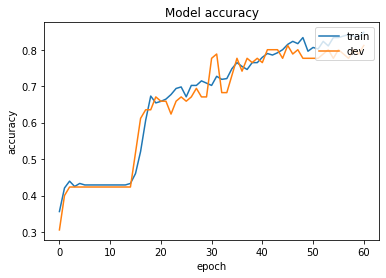

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_39 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_40 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_41 (Dropout)         (None, 150)               0  

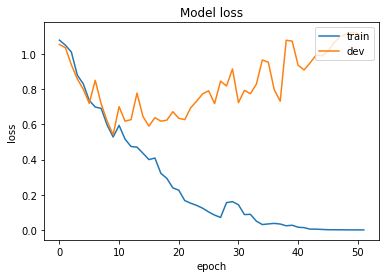

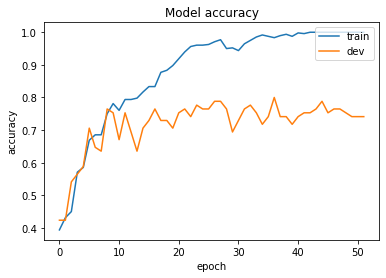

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_42 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_43 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_44 (Dropout)         (None, 150)               0  

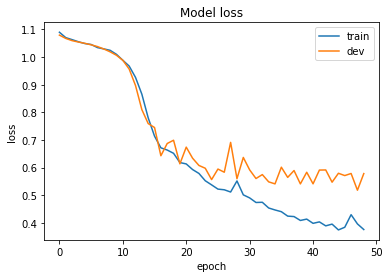

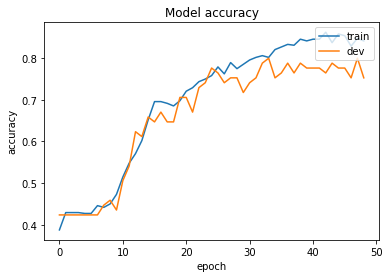

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_45 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_46 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_47 (Dropout)         (None, 150)               0  

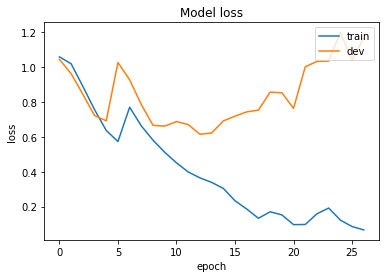

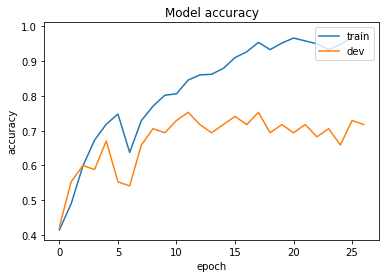

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_48 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_49 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_50 (Dropout)         (None, 75)                0  

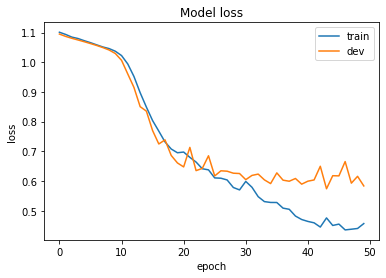

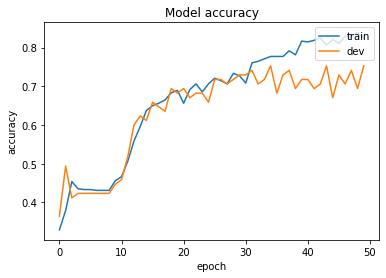

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_51 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_53 (Dropout)         (None, 75)                0  

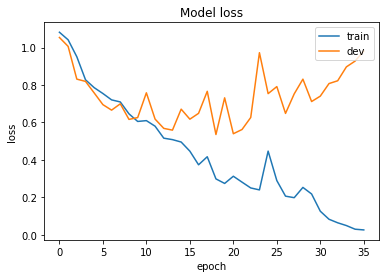

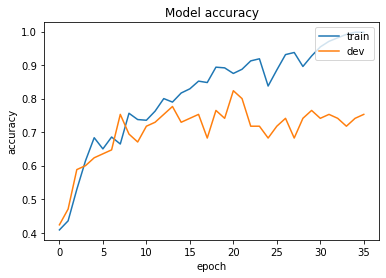

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_54 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_55 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_56 (Dropout)         (None, 75)                0  

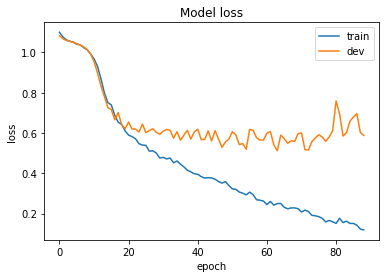

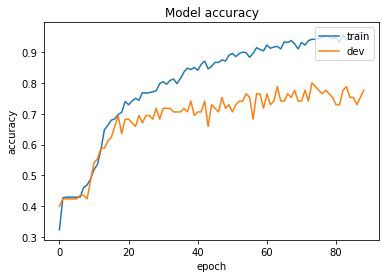

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_57 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_58 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_59 (Dropout)         (None, 75)                0  

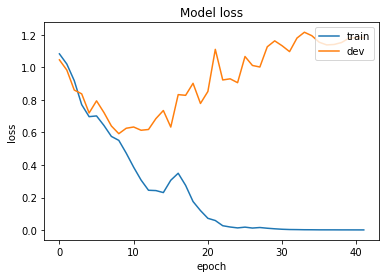

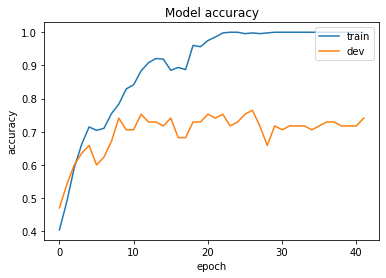

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_60 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_61 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_62 (Dropout)         (None, 75)                0  

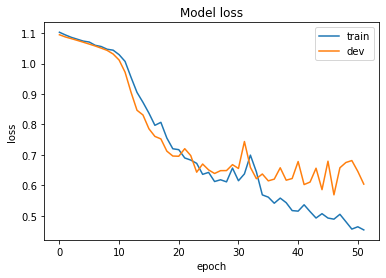

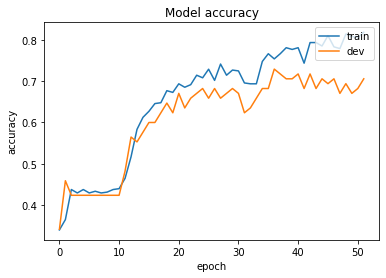

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_63 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_64 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_65 (Dropout)         (None, 75)                0  

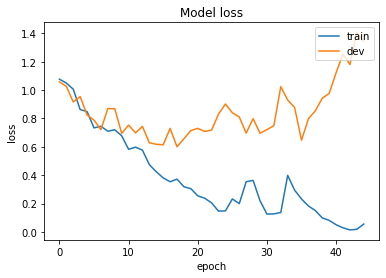

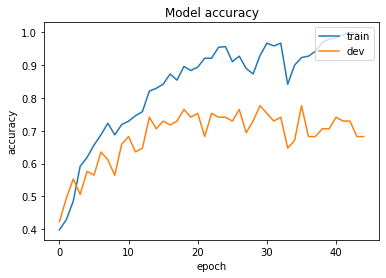

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_66 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_67 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_68 (Dropout)         (None, 75)                0  

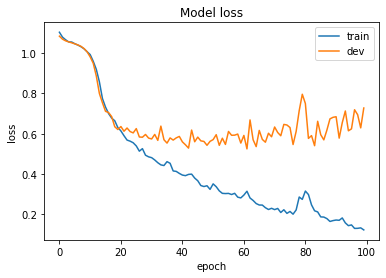

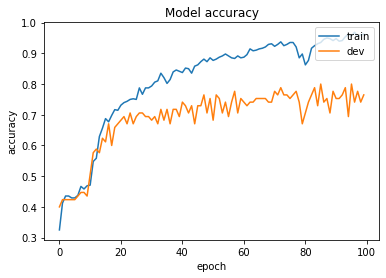

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_69 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_70 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 75)                15075     
_________________________________________________________________
dropout_71 (Dropout)         (None, 75)                0  

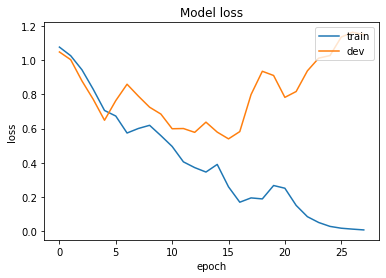

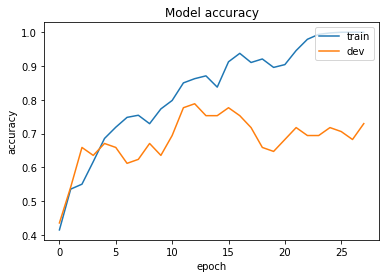

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_72 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_73 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_74 (Dropout)         (None, 150)               0  

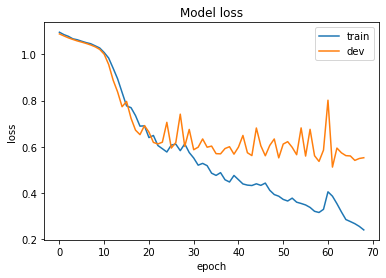

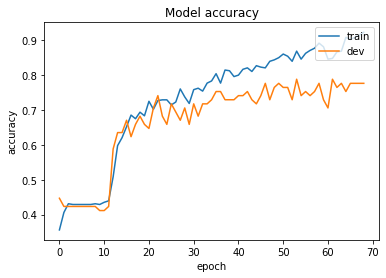

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_75 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_77 (Dropout)         (None, 150)               0  

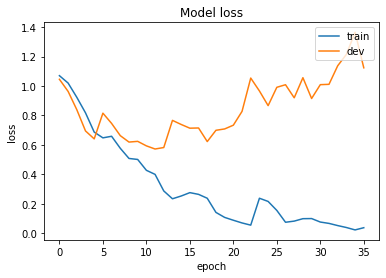

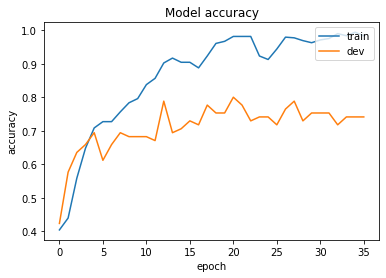

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_78 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_79 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_80 (Dropout)         (None, 150)               0  

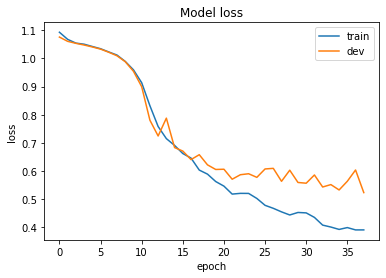

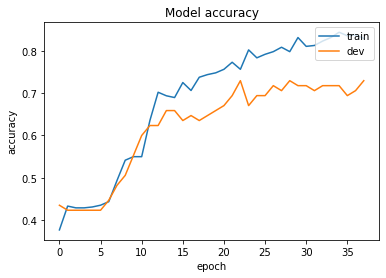

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_81 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_82 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_83 (Dropout)         (None, 150)               0  

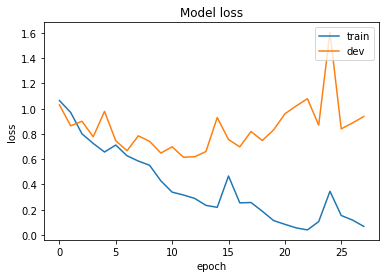

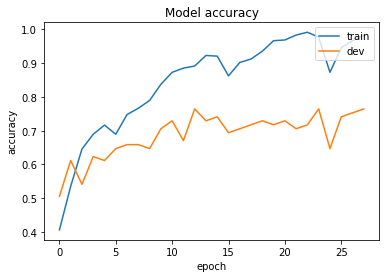

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_84 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_85 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_86 (Dropout)         (None, 150)               0  

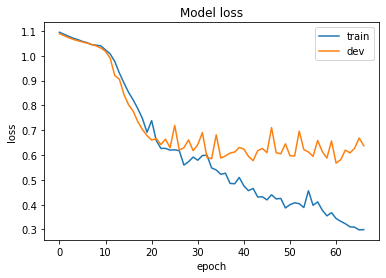

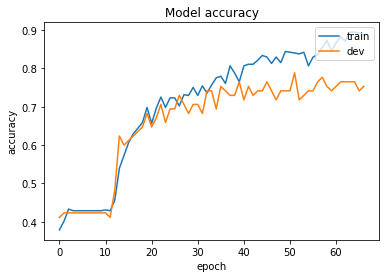

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_87 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_88 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_89 (Dropout)         (None, 150)               0  

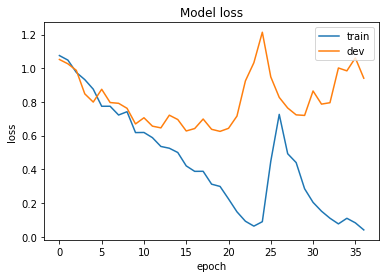

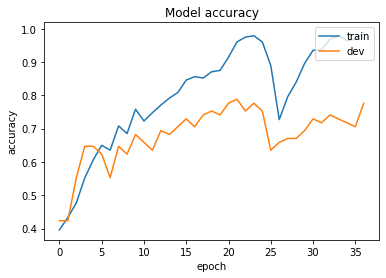

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_90 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_91 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_92 (Dropout)         (None, 150)               0  

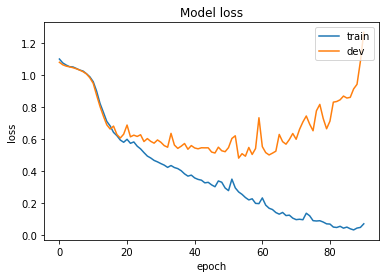

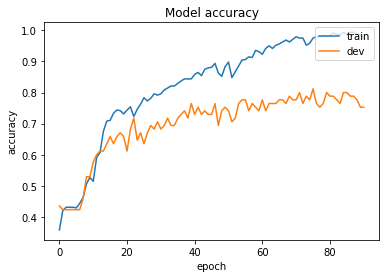

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_93 (Dropout)         (None, 400, 300)          0         
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dropout_94 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_95 (Dropout)         (None, 150)               0  

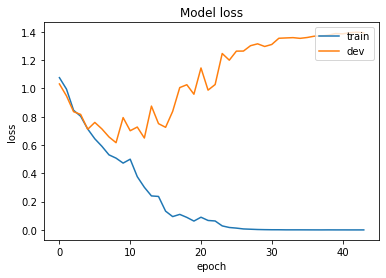

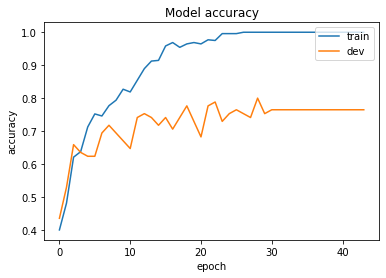

In [ ]:
acc_score = []
f_score = []
loss =[]
baccs = []
counter = 0
# grid search over hyperparameters
for a in recurrent_dropout:
    for b in recurrent_neurons:
        for c in dense_neurons:
            for d in first_dropout:
                for e in later_dropout:
                    for f in activation:
                        for h in learning_rate:
                            for i in learning_rate_rate:

                                decay_lr = h/math.exp(-i)
                                my_adam = Adam(lr=h)#, decay=decay_lr)
                                epochs= 100                                    
                                
                                inputs = Input(shape=(max_length,),)
                                emb = Embedding(vocab, embedding_dim, input_length=max_length, mask_zero=True, weights = [embedding_matrix], trainable=False, embeddings_initializer= initializer)(inputs)
                                dr0 = Dropout( d ,seed=1)(emb)
                                bilstm = Bidirectional(LSTM( b , kernel_initializer=dense_initializer,recurrent_initializer=recurrent_initializer, return_sequences=False, recurrent_dropout=a))(dr0)
                                dr1 = Dropout( e ,seed=1)(bilstm)
                                dense1 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr1)
                                dr2 = Dropout( e ,seed=1)(dense1)
                                dense2 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr2)
                                #dr3 = Dropout( e ,seed=1)(dense2)
                                #dense3 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr3)
                                final = Dense( classes , activation= 'softmax' , kernel_initializer=dense_initializer)(dense2)
                                
                                model = Model(inputs, final)
                                model.compile(loss='categorical_crossentropy',optimizer=my_adam,metrics=['categorical_accuracy'])                                            
#                                checkpoint = ModelCheckpoint('BiRNN_attention', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
                                checkpoint2 = EarlyStopping(monitor='val_categorical_accuracy', verbose=0, patience=15, mode='max', restore_best_weights=True)
                                print(model.summary())
                                history = model.fit(x_train, np.array(ytrain_vector),batch_size=64,epochs=epochs ,verbose = 3, validation_data = (x_dev, np.array(ydev_vector)), shuffle=True, callbacks=[checkpoint2], workers = 1)
                                predictions_probs = model.predict(x_dev)
                                predicted_vectors = np.where([p == max(p) for p in predictions_probs],1,0)
                                #true_labels = encoder.inverse_transform(y_test)
                                #pred_labels = encoder.inverse_transform(predicted_vectors)
                                acc_score.append(accuracy_score(ydev_vector, predicted_vectors))
                                f_score.append(f1_score(ydev_vector, predicted_vectors, average='weighted'))
                                #baccs.append(balanced_accuracy_score(true_labels, pred_labels))
                                loss.append(log_loss(ydev_vector,predictions_probs))
                                counter += 1
                                print(         )
                                print(counter)
                                print()
                                print(f_score[-1])
                                print(loss[-1])
                                print(acc_score[-1])
                                print("\n\n")                                
                                plot(history)



In [ ]:
metrics_dict = pd.DataFrame(np.stack([acc_score,f_score,loss],axis=1), columns = ['acc','f1','loss'])
print(metrics_dict.sort_values(by='acc').tail(10))
print(metrics_dict.sort_values(by='f1').tail(10))
print(metrics_dict.sort_values(by='loss').head(10))

         acc        f1      loss
11  0.800000  0.801821  0.976203
8   0.800000  0.805664  0.645915
25  0.800000  0.803977  0.733598
5   0.800000  0.804249  0.578848
31  0.800000  0.800097  1.315188
12  0.811765  0.815555  0.596631
10  0.811765  0.815651  0.537175
30  0.811765  0.813876  0.651604
17  0.823529  0.824454  0.539877
2   0.823529  0.824454  0.505303
         acc        f1      loss
11  0.800000  0.801821  0.976203
25  0.800000  0.803977  0.733598
14  0.800000  0.804160  0.548652
5   0.800000  0.804249  0.578848
8   0.800000  0.805664  0.645915
30  0.811765  0.813876  0.651604
12  0.811765  0.815555  0.596631
10  0.811765  0.815651  0.537175
17  0.823529  0.824454  0.539877
2   0.823529  0.824454  0.505303
         acc        f1      loss
2   0.823529  0.824454  0.505303
4   0.776471  0.777756  0.536770
10  0.811765  0.815651  0.537175
17  0.823529  0.824454  0.539877
14  0.800000  0.804160  0.548652
6   0.776471  0.780805  0.556394
18  0.800000  0.801134  0.557143
0   0.7882

In [ ]:
metrics_dict.to_csv("dialogue_birrn_tune_categorical_accuracy.csv")

In [ ]:
from numpy.random import seed
seed(1)
#import tensorflow as tf
#tf.random.set_seed(1)
import random
random.seed(1)


classes = len(set(y))
# hyperparameters
initializer = glorot_uniform(seed=1) # Zeros()
recurrent_initializer = glorot_uniform(seed=1) # Zeros()
dense_initializer = glorot_uniform(seed=1)

layers = [2]
recurrent_dropout = [0.0]# ,0.]
recurrent_neurons = [75]
dense_neurons = [75]
first_dropout = [0.]
later_dropout = [0.1]
activation = ['tanh']
final_activation = 'softmax'
learning_rate = [0.0001]
learning_rate_rate = [1]


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 400, 300)          1500300   
_________________________________________________________________
dropout_111 (Dropout)        (None, 400, 300)          0         
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 150)               225600    
_________________________________________________________________
dropout_112 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 75)                11325     
_________________________________________________________________
dropout_113 (Dropout)        (None, 75)                0  

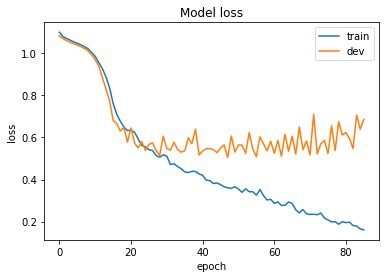

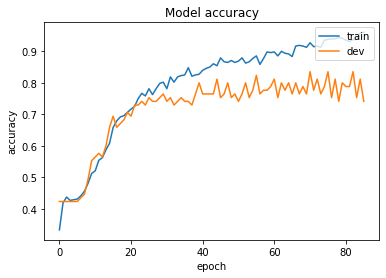

In [ ]:
acc_score = []
f_score = []
loss =[]
baccs = []
counter = 0
# grid search over hyperparameters
for a in recurrent_dropout:
    for b in recurrent_neurons:
        for c in dense_neurons:
            for d in first_dropout:
                for e in later_dropout:
                    for f in activation:
                        for h in learning_rate:
                            for i in learning_rate_rate:

                                decay_lr = h/math.exp(-i)
                                my_adam = Adam(lr=h)#, decay=decay_lr)
                                epochs= 100                                    
                                
                                inputs = Input(shape=(max_length,),)
                                emb = Embedding(vocab, embedding_dim, input_length=max_length, mask_zero=True, weights = [embedding_matrix], trainable=False, embeddings_initializer= initializer)(inputs)
                                dr0 = Dropout( d ,seed=1)(emb)
                                bilstm = Bidirectional(LSTM( b , kernel_initializer=dense_initializer,recurrent_initializer=recurrent_initializer, return_sequences=False, recurrent_dropout=a))(dr0)
                                dr1 = Dropout( e ,seed=1)(bilstm)
                                dense1 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr1)
                                dr2 = Dropout( e ,seed=1)(dense1)
                                dense2 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr2)
                                #dr3 = Dropout( e ,seed=1)(dense2)
                                #dense3 = Dense( c , activation= f ,kernel_initializer=dense_initializer)(dr3)
                                final = Dense( classes , activation= 'softmax' , kernel_initializer=dense_initializer)(dense2)
                                
                                model = Model(inputs, final)
                                model.compile(loss='categorical_crossentropy',optimizer=my_adam,metrics=['categorical_accuracy'])                                            
                                checkpoint = ModelCheckpoint('BiRNN_dialogue.h5', monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
                                checkpoint2 = EarlyStopping(monitor='val_categorical_accuracy', verbose=0, patience=15, mode='max', restore_best_weights=True)
                                print(model.summary())
                                history = model.fit(x_train, np.array(ytrain_vector),batch_size=64,epochs=epochs ,verbose = 3, validation_data = (x_dev, np.array(ydev_vector)), shuffle=True, callbacks=[checkpoint2,checkpoint], workers = 1)
                                predictions_probs = model.predict(x_dev)
                                predicted_vectors = np.where([p == max(p) for p in predictions_probs],1,0)
                                #true_labels = encoder.inverse_transform(y_test)
                                #pred_labels = encoder.inverse_transform(predicted_vectors)
                                acc_score.append(accuracy_score(ydev_vector, predicted_vectors))
                                f_score.append(f1_score(ydev_vector, predicted_vectors, average='weighted'))
                                #baccs.append(balanced_accuracy_score(true_labels, pred_labels))
                                loss.append(log_loss(ydev_vector,predictions_probs))
                                counter += 1
                                print(         )
                                print(counter)
                                print()
                                print(f_score[-1])
                                print(loss[-1])
                                print(acc_score[-1])
                                print("\n\n")                                
                                plot(history)



In [ ]:
test_probs = model.predict(x_test)
test_predicted_vectors = np.where([p == max(p) for p in test_probs],1,0)
print("acc : " , accuracy_score(ytest_vector, test_predicted_vectors))
print("f1 : " , f1_score(ytest_vector, test_predicted_vectors, average='weighted'))
print("loss : " , log_loss(ytest_vector,test_probs))
                                

acc :  0.7142857142857143
f1 :  0.7142857142857143
loss :  0.948047009206632


Predicted    information  other  reservation
True                                        
information           13      3            5
other                  3     11            1
reservation            2      4           21



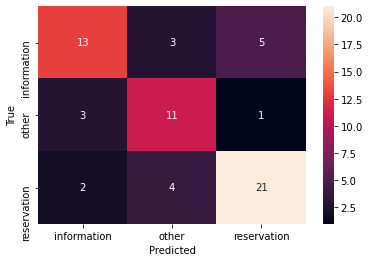

In [ ]:
pred_labels = []
for i in range(len(test_predicted_vectors)):
    if test_predicted_vectors[i][0] == 1:
        pred_labels.append('information')
    elif test_predicted_vectors[i][1] == 1:
        pred_labels.append('other')
    else:
        pred_labels.append('reservation')
        

y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(pred_labels, name='Predicted')
dialogue_correlation = pd.crosstab(y_true, y_pred)
print(dialogue_correlation)
print()

sn.heatmap(dialogue_correlation, annot=True)
plt.show()


In [ ]:
model.save("dialogue_rnn_final_categoricalaccuracytuned.h5")

In [ ]:
def plt_plot(metric, train_scores, test_scores, title='Fold Cross-Validation'):
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    fold = 6
    train_sizes=np.linspace(0.2, 1.0, 5)
    plt.figure()
    plt.title(str(fold)+'-'+title)
    plt.xlabel("Training fraction")
    plt.ylabel(metric)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",label="Test score")
    if metric == 'loss':
        plt.legend(loc="upper right")
    else:
        plt.legend(loc="lower right")
    return plt

def call_model():
    inputs = Input(shape=(max_length,),)
    emb = Embedding(vocab, embedding_dim, input_length=max_length, mask_zero=True, weights = [embedding_matrix], trainable=False, embeddings_initializer= initializer)(inputs)
    dr0 = Dropout( d ,seed=1)(emb)
    bilstm = Bidirectional(LSTM( 200 , kernel_initializer=dense_initializer,recurrent_initializer=recurrent_initializer, return_sequences=False, recurrent_dropout=0.))(dr0)
    dr1 = Dropout( 0.1 ,seed=1)(bilstm)
    dense1 = Dense( 200 , activation= 'tanh' ,kernel_initializer=dense_initializer)(dr1)
    dr2 = Dropout( 0.2 ,seed=1)(dense1)
    dense2 = Dense( 200 , activation= 'tanh' ,kernel_initializer=dense_initializer)(dr2)
    dr3 = Dropout( 0.2 ,seed=1)(dense2)
    dense3 = Dense( 200 , activation= 'tanh' ,kernel_initializer=dense_initializer)(dr3)
    final = Dense( 3 , activation= 'softmax' , kernel_initializer=dense_initializer)(dense3)
    return Model(inputs, final)

In [ ]:
def stratified_learning_curve_rnn(xx, yy, num_cross=10, estimator = model, num_epochs=80, my_optimizer=my_adam, max_length=max_length):
    #xx: dialogues (or sentences) as text, yy: labels (not vectors)
    fold=6
    l_train_scores, l_test_scores, = [], []
    f_train_scores, f_test_scores, = [], []
    a_train_scores, a_test_scores, = [], []
    
    for i in range(num_cross):
        xx = np.array(xx)
        yy = np.array(yy)
        # split the data
        xtrain, ytrain, xtest, y2test = train_dev_test_splitter(xx, yy, fraction=0.166,seed=i)        
        x_rest1, y_rest1, x_part1, y2_part1 = train_dev_test_splitter(xtrain, ytrain, fraction=0.2,seed=2*i+1)
        x_rest2, y_rest2, x_part2, y2_part2 = train_dev_test_splitter(x_rest1, y_rest1, fraction=0.25,seed=i+2)
        x_rest3, y_rest3, x_part3, y2_part3 = train_dev_test_splitter(x_rest2, y_rest2, fraction=0.33,seed=3*i+3)
        x_part5, y2_part5, x_part4, y2_part4 = train_dev_test_splitter(x_rest3, y_rest3, fraction=0.5,seed=5*i+4)
        #convert the labels to onehot vectors
        ytest = y_convert(y2test)
        y_part1 = y_convert(y2_part1)
        y_part2 = y_convert(y2_part2)
        y_part3 = y_convert(y2_part3)
        y_part4 = y_convert(y2_part4)
        y_part5 = y_convert(y2_part5)
        y_partitions = [y_part1,y_part2,y_part3,y_part4,y_part5]
        x_partitions = [x_part1,x_part2,x_part3,x_part4,x_part5]

        l_score_tr, l_score_te = [], []
        f_score_tr, f_score_te = [], []
        a_score_tr, a_score_te = [], []
        for j in range(fold-1):
            if j == 0:
                yyy = y_partitions[0]
                xxx = x_partitions[0]
            else:
                yyy = np.concatenate([y_partitions[j],yyy])
                xxx = np.concatenate([x_partitions[j],xxx])            
            
            train_xxx, train_yyy, dev_xxx, dev_yyy = train_dev_test_splitter(xxx, yyy, fraction=0.1,seed=j+i)        
            tokenizer2 = Tokenizer(num_words=vocab,oov_token='__UNK__')
            tokenizer2.fit_on_texts(train_xxx)            
            train = tokenizer_converter(train_xxx, my_tokenizer = tokenizer2)
            dev = tokenizer_converter(dev_xxx, my_tokenizer = tokenizer2)
            test = tokenizer_converter(xtest, my_tokenizer = tokenizer2)

            rnn = copy.copy(call_model())
            rnn.compile(loss='categorical_crossentropy',optimizer= my_optimizer , metrics=[f1, accuracy])
            checkpoint2 = EarlyStopping(monitor='val_accuracy', verbose=0, patience=15, mode='max', restore_best_weights=True)
            rnn.fit(train, np.array(train_yyy),batch_size=64,epochs= num_epochs ,verbose = 0,callbacks=[checkpoint2],validation_data=(dev, np.array(dev_yyy)),shuffle=True)
            train_pred = rnn.predict(train)
            train_pred_vectors = np.where([p == max(p) for p in train_pred],1,0)
            test_pred = rnn.predict(test)
            test_pred_vectors = np.where([p == max(p) for p in test_pred],1,0)

            f_score_te.append(f1_score(ytest,test_pred_vectors, average='weighted'))
            print(f1_score(ytest,test_pred_vectors, average='weighted'))
            f_score_tr.append(f1_score(train_yyy,train_pred_vectors, average='weighted'))
            l_score_te.append(log_loss(ytest,test_pred))
            l_score_tr.append(log_loss(train_yyy,train_pred))
            a_score_te.append(accuracy_score(ytest,test_pred_vectors))
            a_score_tr.append(accuracy_score(train_yyy,train_pred_vectors))

            print("end of fold " , j+1, " of iteration ", i+1)
        l_train_scores.append(l_score_tr)
        l_test_scores.append(l_score_te)
        f_train_scores.append(f_score_tr)
        f_test_scores.append(f_score_te)
        a_train_scores.append(a_score_tr)
        a_test_scores.append(a_score_te)
    print(plt_plot('f1_weighted',f_train_scores,f_test_scores))
    print(plt_plot('loss',l_train_scores,l_test_scores))
    print(plt_plot('accuracy',a_train_scores,a_test_scores))
    return print("ok!")



In [ ]:
stratified_learning_curve_rnn(x,y, num_cross=5)